# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import ttest_ind
from scipy.stats import percentileofscore
from scipy.stats import norm
from numpy.random import seed
medical = pd.read_csv('data/insurance2.csv')

In [287]:
medical.shape

(1338, 8)

In [288]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

A: The sample distribution of charges plotted below is not normal so the standard deviation is not appropriate and it is very high. The sample size is big (n=1338). The histogram is skewed maybe the median is more appropriate than the mean.

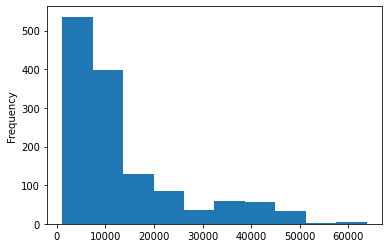

In [289]:
medical['charges'].plot(kind='hist')

In [290]:
mean=np.mean(medical.charges)
mean

13270.422265141257

In [291]:
std=np.std(medical.charges, ddof=1)
std
#medical.charges.std()

12110.011236693994

In [292]:
median=np.median(medical.charges)
#medical.charges.median()
median

9382.033

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

A: Since the sample distribution is not normal we need to bootstrap and then find the probability of getting a mean charge of 12000 or below.

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

A:Appropriate confidence interval for the mean is 95%. One-sided interval from below 12000. Based on our analysis below the confidence interval is (12516.69, 14012.89) which is higher than 12000. However, if we have lower sample numbers the confidence intervals widens and will include the 12,000. The p-value is 0.15 which is below 5%. The administtrator's concern is not necessary.

In [293]:
m = medical.charges.to_numpy()

seed(47)
sample_mean = []

# calculate 100 means sampled from the larger dataset
for n in range(1000):
    this_sample = np.random.choice(m, 100)
    sample_mean.append(np.mean(this_sample))

mean_of_means = np.mean(sample_mean)
std_of_means = np.std(sample_mean, ddof=1)

print("mean of means", mean_of_means, "standard deviation of means:", std_of_means)

mean of means 13283.775887486629 standard deviation of means: 1226.4118801848128


In [294]:
p_val=norm.cdf(12000, loc=13283.78, scale=1226.41)
p_val

0.14760080289565197

In [295]:
means = []
for i in range(10000):
   bootsample = medical.charges.sample(n=1000, replace = True)
   means.append(bootsample.mean())
means = np.array(means)
means.mean()
np.percentile(means, 2.5), np.percentile(means, 97.5)

(12530.377857697162, 14019.12970111702)

In [296]:
p_val=norm.cdf(12000, loc=13262, scale=750)
p_val

0.04621981901788263

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

A:H_0=people with insurance are charged the same amount to those without. H_a=people with insurance are charged a different amount to those without.Assumption is that the variance of the population of both samples are the same.


__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

A:

In [297]:
#all the charges for patients with insurance
insucharges=medical.charges[medical.insuranceclaim>0]
mean_charged_insurance=sum(insucharges)/len(insucharges)
mean_charged_insurance


16423.928276537663

In [298]:
s_insu=np.std(insucharges, ddof=1)
s_insu

14045.928418802127

In [299]:
#number of patients with insurance
l_insu=len(insucharges)
l_insu

783

In [300]:
#all the charges for patients with no insurance
noinsucharges=medical.charges[medical.insuranceclaim<1]
mean_charged_noinsurance=sum(noinsucharges)/len(noinsucharges)
mean_charged_noinsurance

8821.421892306294

In [301]:
s_noinsu=np.std(noinsucharges, ddof=1)
s_noinsu

6446.510126811736

In [302]:
#number of patients with no insurance
l_noinsu=len(noinsucharges)
l_noinsu

555

In [303]:
s_p=(((l_insu-1)*(s_insu)**2+(l_noinsu-1)*(s_noinsu)**2)/(l_insu+l_noinsu-2))**0.5
s_p

11520.034268775256

In [304]:
t_stat=(mean_charged_insurance-mean_charged_noinsurance)/(s_p*((1/l_insu)+(1/l_noinsu))**0.5)
t_stat

11.89329903087671

In [305]:
cdf = t.cdf(-t_stat, df=l_insu+l_noinsu-2)
p_val = 2*cdf 
p_val

4.461230231620972e-31

In [306]:
#percentileofscore(medical.counts,13270)

In [307]:
ttest_ind(insucharges, noinsucharges, equal_var=True)


Ttest_indResult(statistic=11.893299030876712, pvalue=4.461230231620717e-31)

Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

A: zscore method calculates the zscore of a sample but I didn't find a method for calculating the zscore of two samples.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test